<a href="https://colab.research.google.com/github/orbenishay/Regression-Project/blob/Or/Amsterdam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amsterdam Airbnb** 
https://www.kaggle.com/adityadeshpande23/amsterdam-airbnb

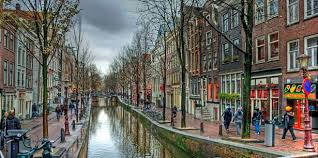


**We introduced some noise to the dataset (which was too clean)**:
*   Outliers (to the overall population's distribution)
*   Outliers (per subset - ex. per number of bedrooms)
*   Bivariate outlier
*   Zero values
*   Null values

**ML Pipeline**:
*   Feature selection
*   Features Relevance
*   Drop columns with high correlation between them in order not to skew the model
*   Scaling where required
*   Order categorical data: in case the order of categorical column is known
*   Target transformation in case required (log price etc.)
*   Split dataset to train/test

**EDA:**
*   Histogram: overall distribution of prices
*   Box/Violin plot: distribution of prices by subset (# bedrooms)
*   Pairplot (scatter matrix) between all the numeric columns
*   Correlation heatmap
*   Correlation matrix
*   Geographical analysis (by coordinates)
*   Pie: proportion of 
*   List item

**Data Cleansing:**
*   Remove entries with zero values (in columns that shouldn't be 0)
*   Remove/replace null values
*   Remove outliers: overall, by subset, bivariate, exponential
*   List item

**Data Manupulation:**
*   Calculate distance from city-center by coordinates
*   Bucket distances to 4 bins
*   Devide locations to North/South, East/West and quartes: NE/NW/SE/SW
*   Convert categorical columns to numeric
*   List item

**Estimators:**

*   KNN
*   Decision trees
*   Linear regression
*   










In [0]:
#Or- clean the notebook,3 data new and predict
#Hagai- EDA, outlier by subset, "double groupby"

In [404]:

import pandas as pd # General tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
from datetime import datetime # Pandas
from datetime import timedelta
from scipy.optimize import curve_fit# For curve fitting
from sklearn.base import TransformerMixin # For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator # For predictions
from sklearn.metrics import mean_squared_log_error as msle # For scoring
from sklearn.metrics import mean_squared_error as mse # For scoring
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import pydot as pyd # For the tree visualization
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split # For validation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
!pip install pydot;
# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse


In [284]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving Amsterdam2.csv to Amsterdam2 (3).csv


In [463]:
bnb_orig = pd.read_csv('Amsterdam2.csv', index_col='#')
bnb=bnb_orig

bnb['ring']=pd.cut(x=bnb['d_centre'], bins=4, right=True, labels=['Center','Off Center','periphery','Suburbs'],\
retbins=False, precision=3, include_lowest=False, duplicates='raise') # bin distance  

bnb['N_S']=np.where(bnb['latitude']>=52.37854617, 'North', 'South')
bnb['E_W']=np.where(bnb['longitude']>=4.900774603, 'East', 'West')
bnb['Quarter']=bnb['N_S']+"_"+bnb['E_W']
#bnb= bnb.drop(['guests_included', 'host_listings_count'], axis=1)

bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,calculated_host_listings_count,guests_included,host_listings_count,minimum_nights,number_of_reviews,instant_bookable,room_type,review_avg,price,ring,N_S,E_W,Quarter
#,,,,,,,,,,,,,,,,,,,
7656,52.345678,4.894957,3.736228,1.0,0.0,1.0,1,1,1,0,0,Not Possible,Private room,0.805394,42,Center,South,West,South_West
9768,52.345389,4.817839,6.690642,1.0,0.0,1.0,2,1,2,1,16,Not Possible,Shared room,0.708962,25,Off Center,South,West,South_West
456,52.362756,4.951517,3.977813,2.0,0.0,1.0,1,1,1,1,87,Not Possible,Private room,0.768062,75,Off Center,South,East,South_East
2578,52.344844,4.898198,3.817490,2.0,0.0,1.0,4,1,4,1,8,Not Possible,Private room,0.787619,85,Center,South,West,South_West
3844,52.367105,4.860719,2.949743,2.0,0.0,1.0,3,1,7,1,3,Not Possible,Private room,0.740230,75,Center,South,West,South_West


## **Data Cleansing**

In [0]:
bnb = bnb[bnb.isnull().sum(axis=1)<1] # Remove rows with more than 1 `NaN`'s.

In [0]:
bnb = bnb.loc[:, ~bnb.columns.str.contains(r'review', case=False)] # remove specific columns

In [0]:
bnb = bnb.loc[:, ~bnb.columns.str.contains(r'calculated', case=False)] # remove specific columns

In [0]:
bnb.drop_duplicates(inplace=True) # Remove duplicates

In [0]:
bnb.drop_duplicates(subset=['latitude', 'longitude'], inplace=True) # Remove duplicates with subsets: Only consider certain columns for identifying duplicates, by default use all of the columns

In [469]:
bnb.index.value_counts().sort_values(ascending=False).head() # look for duplications

2049     1
2081     1
10245    1
12294    1
14343    1
Name: #, dtype: int64

In [470]:
bnb.shape # after each cleaning step: check how many rows were deleted 

(14996, 16)

In [0]:
bnb = bnb.loc[bnb['bedrooms']<6,:] # filter dataset based on a column's values

In [0]:
bnb = bnb.loc[bnb['price']<500,:] # filter dataset based on a column's values

In [473]:
for col in [bnb.longitude, bnb.latitude, bnb.d_centre, bnb.price, bnb.minimum_nights]: # remove outliers >3 sigma from all the fields
        std = col.std()       
        ave = col.mean()
        bnb = bnb.loc[col.between(ave-6*std, ave+6*std)]


bnb.shape

(14950, 16)

In [474]:
#bnb_bedrooms= bnb.groupby('bedrooms').agg({'price': 'mean'})
bnb_bedrooms= bnb.groupby('bedrooms')['price'].mean()
bnb_bedrooms_std= bnb.groupby('bedrooms')['price'].quantile([0.25,0.75]).unstack(-1)
bnb.shape

(14950, 16)

In [0]:
def drop_zeros(df): # remove zeros with 0 values at either columns
    return df.loc[df.accommodates * df.minimum_nights * df.price != 0]
zeros_dropper = FunctionTransformer(drop_zeros, validate=False)
bnb = zeros_dropper.fit_transform(bnb)

In [0]:
# xz_model = LinearRegression().fit(diamonds[['x']], diamonds.z) # remove bivariate outliers
# z_pred = xz_model.predict(diamonds[['x']])
# diamonds = diamonds.loc[(diamonds.z-z_pred).abs()<0.35]

# x_carat_model = LinearRegression().fit(diamonds[['x']], diamonds.carat) # remove by linear regression
# carat_pred = x_carat_model.predict(diamonds[['x']])
# diamonds = diamonds.loc[(diamonds.carat-carat_pred).abs()<0.3]
# sns.scatterplot(x='x', y='carat', data=diamonds)

# def exponential(x, a, b, c, d): # remove by exponential regression
#     return a + b*np.exp(c*x+d)
# popt, _ = curve_fit(exponential, xdata=diamonds.x, ydata=diamonds.carat)
# print(popt)
# a, b, c, d = popt
# carat_pred = diamonds.x.apply(exponential, a=a, b=b, c=c, d=d) # plot the curve
# plt.plot(diamonds.x, diamonds.carat, '.b', 
#               diamonds.x, carat_pred, '.g')
# plt.text(6, 0.5, r'$carat = -0.47+19.56 x exp(0.3x-4.56)$')
# residuals = (diamonds.carat - carat_pred).abs() #evaluate the residuals and remove data points as we wish.
# residuals.hist(bins=100)


processing latitude   --> 13622 assets remain
processing longitude  --> 13553 assets remain
processing d_centre   --> 13454 assets remain
processing accommodates --> 13212 assets remain
processing bathrooms  --> 12820 assets remain
processing bedrooms   --> 12820 assets remain


## **Dataset explration**

In [476]:
bnb.loc[:,['d_centre','price']].head() # slice dataframe (show specific columns)

,d_centre,price
#,,
9768,6.690642,25
456,3.977813,75
2578,3.817490,85
3844,2.949743,75
4466,3.008866,85


In [477]:
bnb.bedrooms.loc[:,].count() # count of entries in a column of a df

14948

In [456]:
bnb.shape # dimention of df

(14948, 16)

In [478]:
bnb[['room_type','price']].groupby('room_type').describe() # describe with subset

price                         ...                      
                   count        mean        std  ...    50%     75%    max
room_type                                        ...                      
Entire home/apt  11612.0  142.191095  63.278557  ...  125.0  165.00  440.0
Private room      3272.0   86.876528  40.965839  ...   79.0  100.00  400.0
Shared room         64.0   89.000000  65.628101  ...   64.0  112.25  385.0

[3 rows x 8 columns]

In [479]:
bnb.bedrooms.value_counts().head(10) #Count entries per value:

1.0    9213
2.0    3445
3.0    1022
0.0     899
4.0     333
5.0      36
Name: bedrooms, dtype: int64

In [480]:
bnb.loc[:,['d_centre','price']] # slice dataframe (show specific columns)
bnb.bedrooms.loc[:,].count() # count of entries in a column of a df
bnb.shape # dimention of df
bnb[['room_type','price']].groupby('room_type').describe() # describe with subset
bnb.bedrooms.value_counts().head(10) #Count entries per value:
bnb.nunique() # how many values per field

latitude               14926
longitude              14948
d_centre               14948
accommodates              13
bathrooms                 12
bedrooms                   6
guests_included           13
host_listings_count       32
minimum_nights            27
instant_bookable           2
room_type                  3
price                    320
ring                       4
N_S                        2
E_W                        2
Quarter                    4
dtype: int64

## **Transformation**

In [481]:
# non-numerical data into numerical data - utilize the "order" of the categories
room_type_order = ['Entire home / apt', 'Private room', 'Shared room']
room_type_map = dict(zip(room_type_order, range(len(room_type_order))))
bnb.loc[:, 'room_type_n'] = bnb['room_type'].map(room_type_map) #
bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable,room_type,price,ring,N_S,E_W,Quarter,room_type_n
#,,,,,,,,,,,,,,,,,
9768,52.345389,4.817839,6.690642,1.0,0.0,1.0,1,2,1,Not Possible,Shared room,25,Off Center,South,West,South_West,2.0
456,52.362756,4.951517,3.977813,2.0,0.0,1.0,1,1,1,Not Possible,Private room,75,Off Center,South,East,South_East,1.0
2578,52.344844,4.898198,3.817490,2.0,0.0,1.0,1,4,1,Not Possible,Private room,85,Center,South,West,South_West,1.0
3844,52.367105,4.860719,2.949743,2.0,0.0,1.0,1,7,1,Not Possible,Private room,75,Center,South,West,South_West,1.0
4466,52.366334,4.860399,3.008866,2.0,0.0,1.0,1,7,1,Not Possible,Private room,85,Center,South,West,South_West,1.0


In [461]:
bnb['instant_bookable_boo'] = bnb['instant_bookable'].replace({'Not Possible': 0, 'Possible': 1})
bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable,room_type,price,ring,N_S,E_W,Quarter,room_type_n,instant_bookable_boo
#,,,,,,,,,,,,,,,,,,
9768,52.345389,4.817839,6.690642,1.0,0.0,1.0,1,2,1,Not Possible,Shared room,25,Off Center,South,West,South_West,2.0,0
456,52.362756,4.951517,3.977813,2.0,0.0,1.0,1,1,1,Not Possible,Private room,75,Off Center,South,East,South_East,1.0,0
2578,52.344844,4.898198,3.817490,2.0,0.0,1.0,1,4,1,Not Possible,Private room,85,Center,South,West,South_West,1.0,0
3844,52.367105,4.860719,2.949743,2.0,0.0,1.0,1,7,1,Not Possible,Private room,75,Center,South,West,South_West,1.0,0
4466,52.366334,4.860399,3.008866,2.0,0.0,1.0,1,7,1,Not Possible,Private room,85,Center,South,West,South_West,1.0,0


In [399]:
# non-numerical data into numerical data - utilize the "order" of the categories
#ring_order = ['Center','Off Center','periphery','Suburbs']
#ring_order_map = dict(zip(ring_order, range(len(ring_order))))
#bnb.loc[:, 'ring_n'] = bnb['ring'].map(ring_order_map) #
#bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable,room_type,price,ring,N_S,E_W,Quarter,instant_bookable_boo,room_type_n,ring_n
#,,,,,,,,,,,,,,,,,,,
9768,52.345389,4.817839,6.690642,1.0,0.0,1.0,1,2,1,Not Possible,Shared room,25,Off Center,South,West,South_West,0,2.0,1
456,52.362756,4.951517,3.977813,2.0,0.0,1.0,1,1,1,Not Possible,Private room,75,Off Center,South,East,South_East,0,1.0,1
2578,52.344844,4.898198,3.817490,2.0,0.0,1.0,1,4,1,Not Possible,Private room,85,Center,South,West,South_West,0,1.0,0
3844,52.367105,4.860719,2.949743,2.0,0.0,1.0,1,7,1,Not Possible,Private room,75,Center,South,West,South_West,0,1.0,0
4466,52.366334,4.860399,3.008866,2.0,0.0,1.0,1,7,1,Not Possible,Private room,85,Center,South,West,South_West,0,1.0,0


In [0]:
X = diamonds.drop('price', axis=1, inplace=False)
y = diamonds.price
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=142857) # this splits the dataset randomly but the same way

p_opt, _ = curve_fit(diamond_pricing, X_train, y_train) # apply curve fit

prms = dict(zip(['a', 'b', 'c', 'd'], p_opt))
print(prms)

y_pred = X_train.apply(diamond_pricing, axis=1, **prms)

# Convert categorical fields to numeric:
people_dummies = pd.get_dummies(people, drop_first=True)

## **EDA**

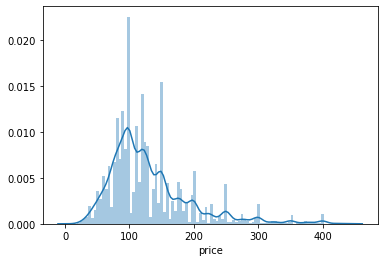

In [426]:
# bnb.hist(column='price', by='instant_bookable', bins=50, sharex=True, sharey=True);
sns.distplot(bnb.price, bins=100, kde=True); #---------------------------- kde?
# bnb[['price']].sort_values('price', ascending=False).head(20)

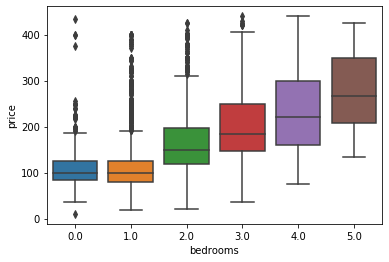

In [427]:
sns.boxplot(x='bedrooms', y='price', hue=None, data=bnb, order=None, hue_order=None);

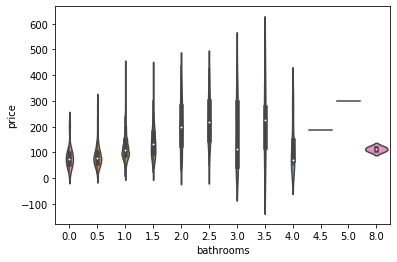

In [428]:
sns.violinplot(x='bathrooms', y='price', data=bnb); #order=cut_order

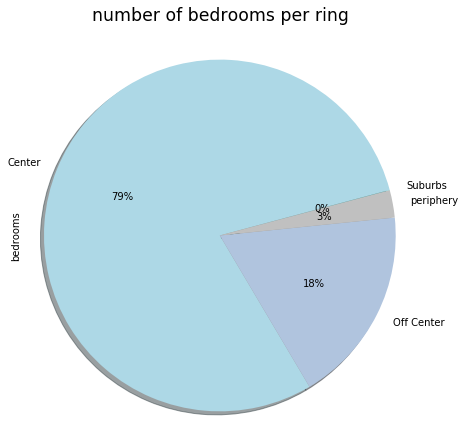

In [429]:
my_colors = ['lightblue','lightsteelblue','silver','lightseagreen','khaki','peachpuff']
Pie = bnb.groupby('ring')['bedrooms'].sum().plot.pie(autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True,figsize=(7, 7))
plt.title('number of bedrooms per ring', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.axis('equal')
plt.show()

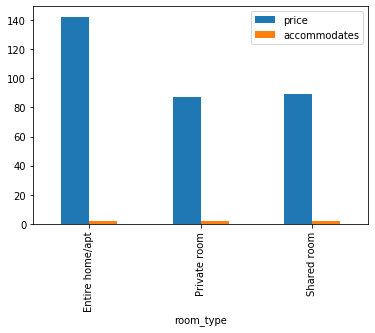

In [430]:
bnb.groupby('room_type').agg({'price': 'mean', 'accommodates': 'median'}).plot(kind='bar');


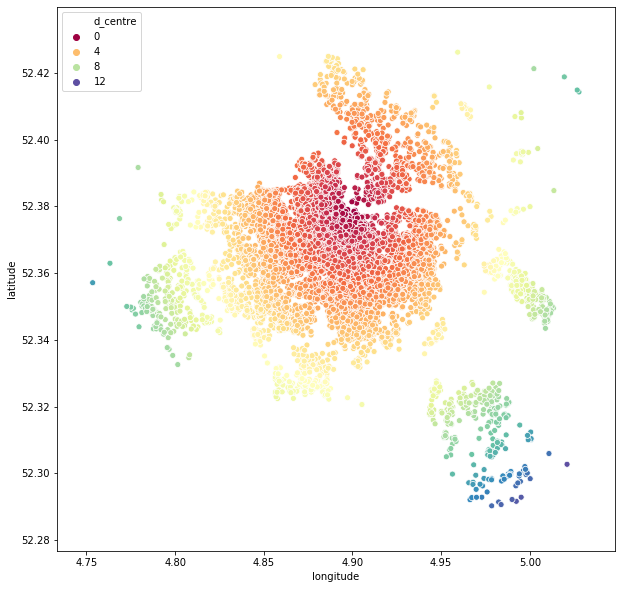

In [431]:
# ax = bnb.plot(kind = 'scatter',x='longitude',y='latitude', c='d_centre',colormap='viridis', figsize = (10, 10))
plt.figure(figsize=(10,10))
# sns.scatterplot(x='longitude', y='latitude', hue='ring', data=bnb, palette="Spectral");
sns.scatterplot(x='longitude', y='latitude', hue='d_centre', data=bnb, palette="Spectral");
# sns.scatterplot(x='longitude', y='latitude', hue='Quarter', data=bnb, palette="cubehelix");



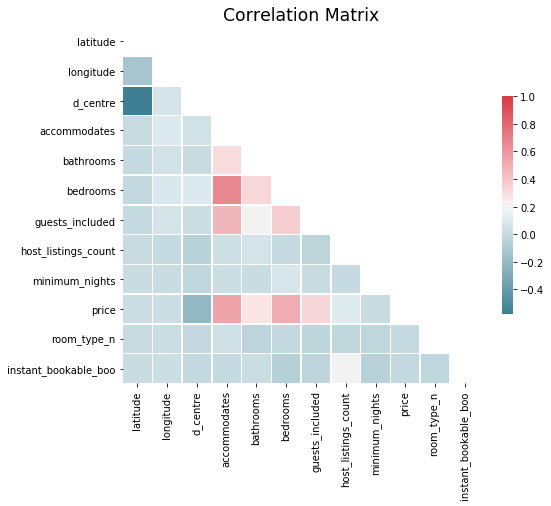

In [432]:
# Correlation matrix:
corr = bnb.corr()
mask = np.zeros_like(corr, dtype=np.bool) #Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8,8)) #Setting up the matplotlib figure
cmap = sns.diverging_palette(220,10, as_cmap=True) #Generating a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax) #Drawing the heatmap with the mask
plt.title("Correlation Matrix", fontsize='xx-large')
plt.show()

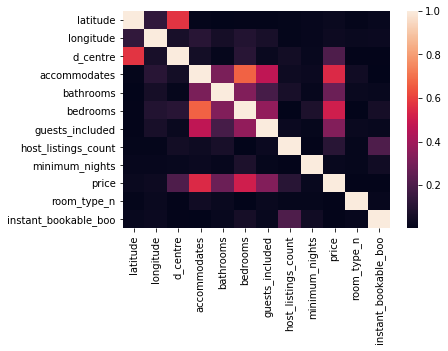

In [433]:
sns.heatmap(bnb.corr().abs())

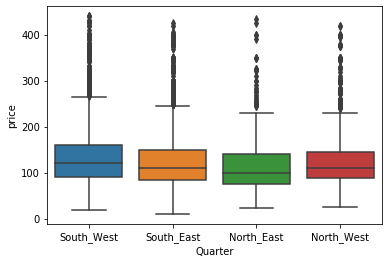

In [434]:
sns.boxplot(x='Quarter', y='price', hue=None, data=bnb, order=None, hue_order=None);

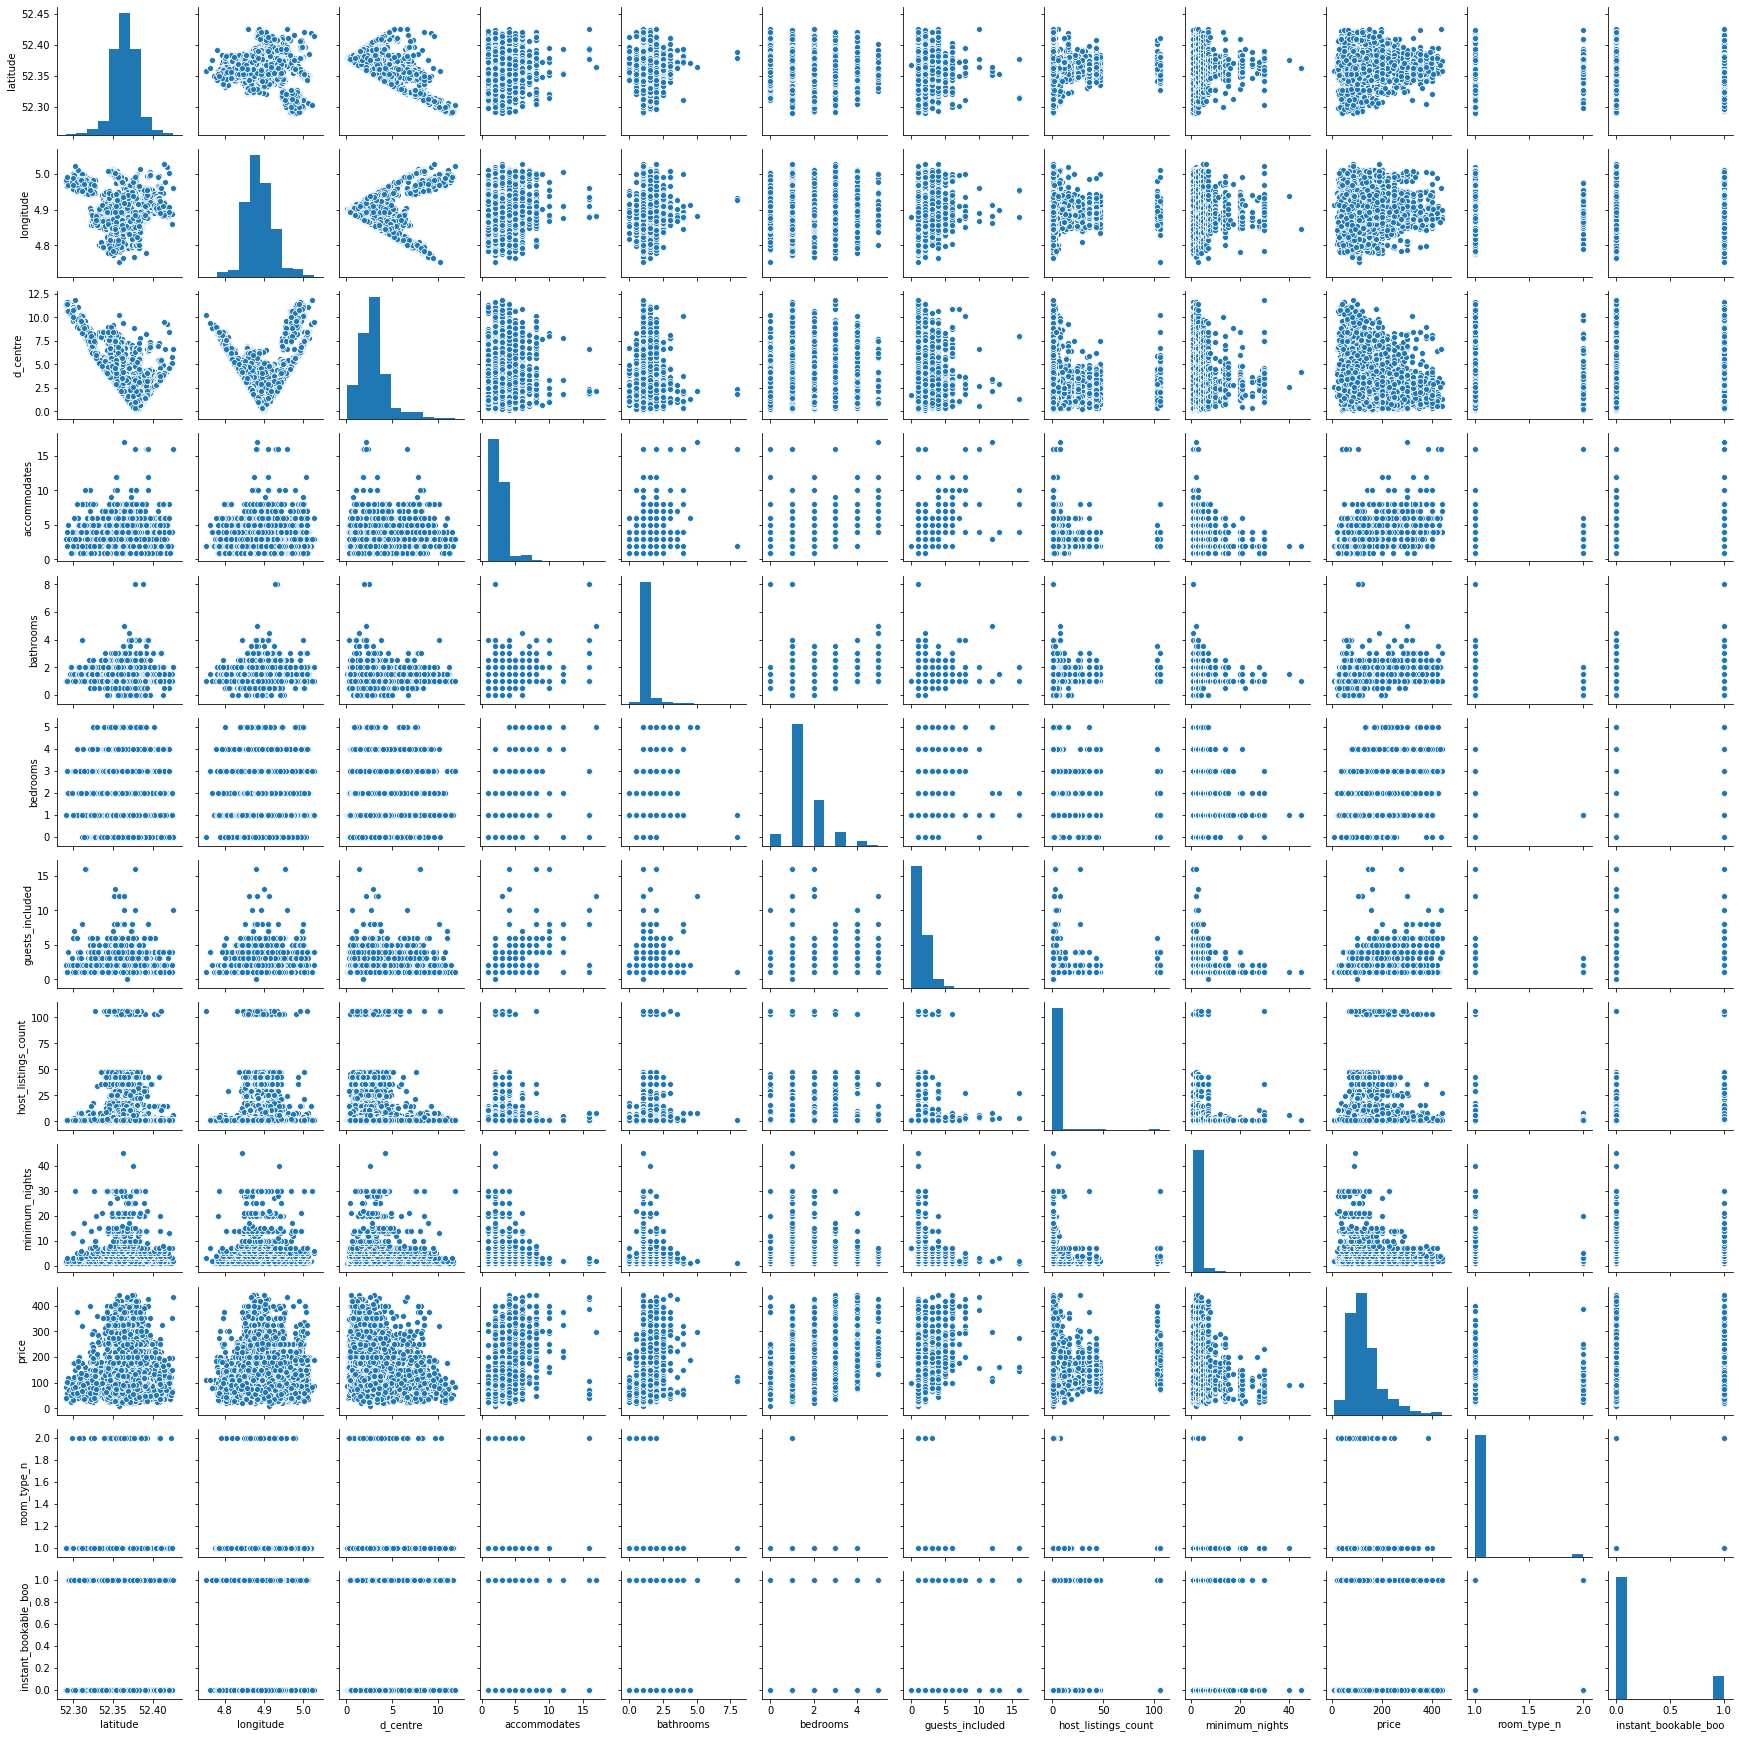

In [435]:
bnb_num = bnb.select_dtypes(include=np.number)
sns.pairplot(bnb_num, height=2)

## **Splitting the data**

In [0]:
bnb_num = bnb.select_dtypes(include=np.number)

In [0]:
X = bnb_num.drop('price', axis=1, inplace=False)
y = bnb_num.price
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=142857) # this splits the dataset randomly but the same way

## Scoring

In [0]:
def rmsle(y_true, y_pred): # function for scoring the model
    return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

# **Models**

## Decision tree

In [489]:
bnb_model = DecisionTreeRegressor(min_samples_split=10, min_impurity_split=0.0001)
bnb_model.fit(X_train, y_train)


ValueError: ignored

In [0]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pyd.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=1200) 

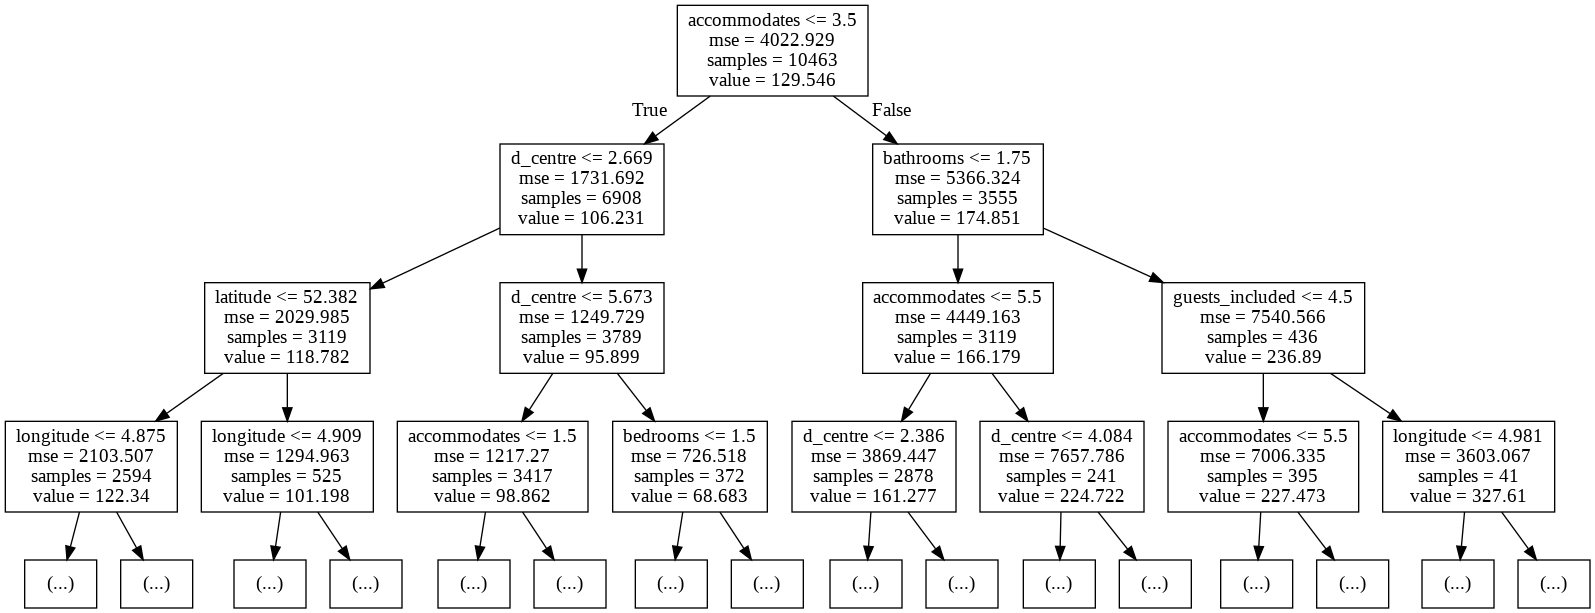

In [384]:
visualize_tree(bnb_model, 3)

In [385]:
for feature, importance in zip(X.columns, bnb_model.feature_importances_):
    print('{:12}: {}'.format(feature, importance))

latitude    : 0.13202401516624876
longitude   : 0.12710531130402472
d_centre    : 0.1583539637670154
accommodates: 0.36601898243291275
bathrooms   : 0.06498036032371814
bedrooms    : 0.04655512970074669
guests_included: 0.042048183581942206
host_listings_count: 0.03398984739449473
minimum_nights: 0.028924206328896612


In [0]:
y_train_pred = bnb_model.predict(X_train)

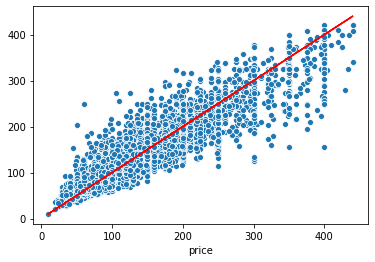

In [387]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [388]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

25.047694994428547

In [0]:
y_test_pred = bnb_model.predict(X_test)

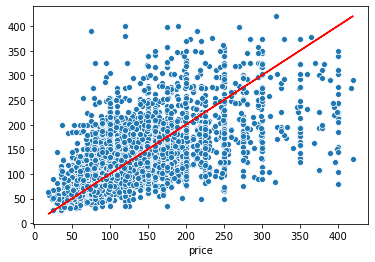

In [390]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [391]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

55.66914593904247

## KNN

In [0]:
bnb_model_knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

In [0]:
y_train_pred = bnb_model_knn.predict(X_train)

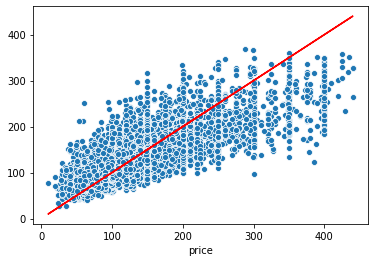

In [394]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [395]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

39.94693268509044

In [0]:
y_test_pred = bnb_model_knn.predict(X_test)

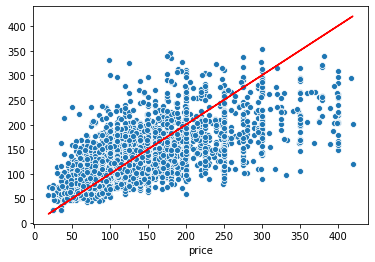

In [397]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [372]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

39.94693268509044

## Regression Model

In [0]:
bnb_lin = LinearRegression().fit(X_train, y_train)

In [374]:
list(zip(X_train.columns, bnb_lin.coef_))

[('latitude', -758.1519712453018),
 ('longitude', -62.87128864180096),
 ('d_centre', -14.063086020072646),
 ('accommodates', 16.20750233057023),
 ('bathrooms', 13.442486652850828),
 ('bedrooms', 22.174464208993598),
 ('guests_included', 5.675340624394403),
 ('host_listings_count', 0.44015469524519624),
 ('minimum_nights', -0.47796125075193263)]

In [0]:
y_train_pred = bnb_lin.predict(X_train)

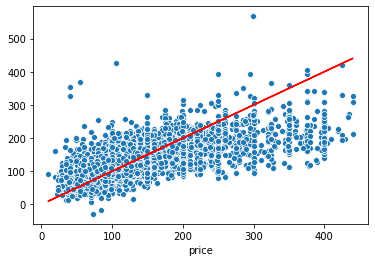

In [376]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [377]:
mse(y_train, y_train_pred)**0.5

47.34106670236043

In [0]:
y_test_pred = bnb_lin.predict(X_test)

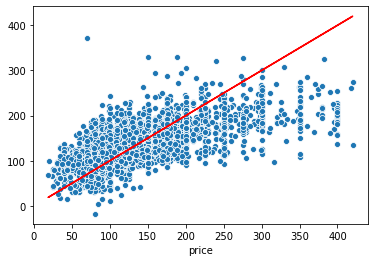

In [379]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [380]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

46.86524335545657